In [1]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
from collections import deque
from features import *

In [2]:
with open('params/svc_pickle.p', 'rb') as f:
    params = pickle.loads(f.read())

cell_per_block = params['cell_per_block']
hist_bins = params['hist_bins']
orient = params['orient']
pix_per_cell = params['pix_per_cell']
X_scaler = params['scaler']
spatial_size = params['spatial_size']
svc = params['svc']

In [ ]:
for img_name in ['./examples/car.png', './examples/notcar.png']:
    img = mpimg.imread(img_name)
    original_img = np.copy(img)
    fig, axes = plt.subplots(ncols=4, nrows=2)
    fig.set_size_inches(10, 6)
    axes[0][0].imshow(original_img)
    axes[0][0].set(title='Original image', xticks=[], yticks=[])
    img = convert_color(img, conv='RGB2YCrCb')
    for i in range(3):
        axes[0][i+1].imshow(img[:, :, i], cmap='Greys_r')
        axes[0][i+1].set(title=['Y', 'Cr', 'Cb'][i] + ' channel', xticks=[], yticks=[])
    
    axes[1][0].imshow(original_img)
    axes[1][0].set(title='Original image', xticks=[], yticks=[])
    for i in range(3):
        _, hog_image = get_hog_features(img[:, :, i], orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, vis=True)
        axes[1][i+1].imshow(hog_image, cmap='Greys_r')
        axes[1][i+1].set(title=['Y', 'Cr', 'Cb'][i] + ' channel HOG', xticks=[], yticks=[])
    plt.show()
    name = img_name.split('.png')[0] + '-features.png'
    fig.savefig(name)

In [ ]:
img = mpimg.imread('test_images/test2.jpg')
ystart, ystop = int(img.shape[0]*.5), int(img.shape[0]*.95)
img_cropped = img[ystart:ystop, :, :]
img_cropped = convert_color(img_cropped, conv='RGB2YCrCb')
img_cropped = img_cropped.astype(np.float32)/255
fig, axes = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(14, 8)
axes[0][0].imshow(img)
axes[0][0].set(title='Original image', xticks=[], yticks=[])
for scale in [1, 2, 3]:
    draw_img = np.copy(img)
    gen = find_cars(img_cropped, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    for bbox in gen:
        bbox[0] = (bbox[0][0], ystart + bbox[0][1])
        bbox[1] = (bbox[1][0], ystart + bbox[1][1])
        cv2.rectangle(draw_img, bbox[0], bbox[1], (0, 255, 0), 3)
    i, j = (0, 1) if scale==1 else (1, 0) if scale==2 else (1, 1)
    axes[i][j].imshow(draw_img)
    axes[i][j].set(title='Scale '+str(scale), xticks=[], yticks=[])
plt.show()
# fig.savefig('./examples/scales.png')

In [27]:
from scipy.ndimage.measurements import label

def process_frame(img):
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    
    ystart, ystop = int(img.shape[0]*.5), int(img.shape[0]*.95)
    img_cropped = img[ystart:ystop, :, :]
    img_cropped = convert_color(img_cropped, conv='RGB2YCrCb')
    img_cropped = img_cropped.astype(np.float32)/255
    for scale in [1, 2]:
        gen = find_cars(img_cropped, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        for bbox in gen:
            bbox[0] = (bbox[0][0], ystart + bbox[0][1])
            bbox[1] = (bbox[1][0], ystart + bbox[1][1])
            cv2.rectangle(draw_img, bbox[0], bbox[1], (0, 255, 0), 3)
            heatmap[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] += 1
    process_frame.buffer.append(heatmap)
    
    heatmap = np.dstack((heatmap*20, np.zeros_like(heatmap), np.zeros_like(heatmap))).astype(np.uint8)
    img1 = np.concatenate((draw_img, heatmap), axis=1)
        
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    for i in range(len(process_frame.buffer)):
        heatmap += process_frame.buffer[i]
    heatmap[heatmap < process_frame.threshold] = 0
    labels = label(heatmap)
    img2 = np.zeros_like(img)
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        img2[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] = (255, 255, 255)
    img1 = np.concatenate((img1, img2), axis=1)
    plt.imsave('frames/frame-{}.jpg'.format(process_frame.frame_counter), img1)
    process_frame.frame_counter += 1
    return img1

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [29]:
process_frame.frame_counter = 0
process_frame.threshold = 20
process_frame.buffer = deque(maxlen=10)
white_output = 'test_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:53<00:01,  1.40s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 50.1 s, sys: 2.36 s, total: 52.5 s
Wall time: 55.6 s


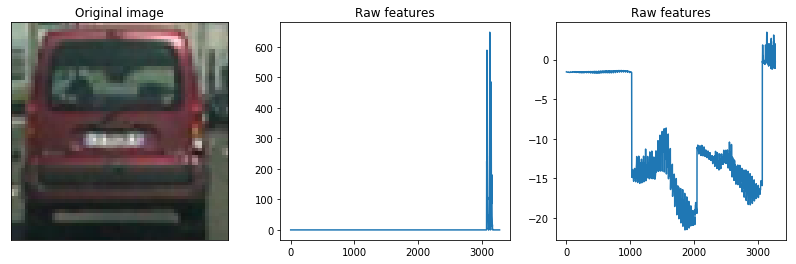

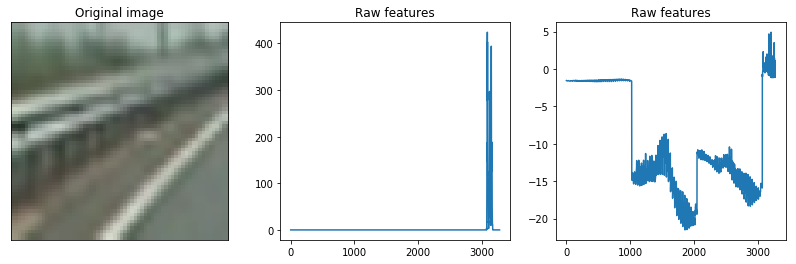

In [40]:
for img_name in ['./examples/car.png', './examples/notcar.png']:
    img = mpimg.imread(img_name)
    original_img = np.copy(img)
    img = convert_color(img, conv='BGR2YCrCb')
    img = img.astype(np.float32)/255
    features = get_window_features(img, orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins)

    f = next(features)
    fig, axes = plt.subplots(ncols=3, nrows=1)
    fig.set_size_inches(14, 4)
    axes[0].imshow(original_img)
    axes[0].set(title='Original image', xticks=[], yticks=[])
    
    axes[1].plot(f[0])
    axes[1].set(title='Raw features')
    
    f = X_scaler.transform(f)
    axes[2].plot(f[0])
    axes[2].set(title='Raw features')
    plt.show()